# 📊 Taxi Pricing Analysis - UPDATED FOR APPLE-TO-APPLE COMPARISON

**✅ NOW SUPPORTS:** Both revenue and total value comparisons

## 🍎 Two Ways to Compare Methods

### 1. Revenue Comparison (Customer Perspective)
- **Field:** `profit` (price only)
- **Shows:** Which method generates more customer revenue
- **Use for:** Business revenue analysis

### 2. Total Value Comparison (System Perspective)  
- **Field:** `total_value` (price + edge_weight)
- **Shows:** Which method is more efficient overall
- **Use for:** System optimization analysis
- **Can compare:** LP optimal vs realized (apple-to-apple!)

## 📝 Note on Data Compatibility

- **Old experiments:** Only have `profit` field → Revenue analysis only
- **New experiments:** Have `profit` + `total_value` → Both analyses available

This notebook automatically detects which fields are available.

In [11]:
# Essential Imports and S3 Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
import io
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 8)

PLOTS_DIR = Path('plots')
PLOTS_DIR.mkdir(exist_ok=True)

# S3 Configuration
S3_BUCKET = "taxi-benchmark"
S3_EXPERIMENTS_PREFIX = "experiments/"
AWS_REGION = "eu-north-1"

s3_client = boto3.client('s3', region_name=AWS_REGION)

print("📊 S3 Taxi Analysis - Ready!")
print(f"📁 Plots: {PLOTS_DIR.absolute()}")

📊 S3 Taxi Analysis - Ready!
📁 Plots: /Users/borker/mgr/taxibenchmark/plots


In [12]:
df = pd.read_parquet("s3://taxi-benchmark/experiments/20191006_yellow_Man_LP_MinMaxCostFlow_20251115_122937/decisions/time_window_0000.parquet")

In [13]:
df.head(10)

,time_window_idx,time_window,borough,method,acceptance_function,requester_id,price,acceptance_prob,sampled_decision,was_matched,profit,edge_weight,total_value,compute_time,opt_value
0,0,"TimeWindow(start=datetime.datetime(2019, 10, 6...",Manhattan,LP,PL,0,8.529057,0.663272,1,0,8.529057,0.000000,0.000000,78.682726,1227.614857
1,0,"TimeWindow(start=datetime.datetime(2019, 10, 6...",Manhattan,LP,PL,1,9.697421,0.663272,0,1,0.000000,-1.583468,8.113953,78.682726,1227.614857
2,0,"TimeWindow(start=datetime.datetime(2019, 10, 6...",Manhattan,LP,PL,2,11.195468,0.791821,1,1,11.195468,-1.357403,9.838065,78.682726,1227.614857
3,0,"TimeWindow(start=datetime.datetime(2019, 10, 6...",Manhattan,LP,PL,3,11.372122,0.791821,1,1,11.372122,-1.671624,9.700498,78.682726,1227.614857
4,0,"TimeWindow(start=datetime.datetime(2019, 10, 6...",Manhattan,LP,PL,4,11.333949,0.853419,1,1,11.333949,-1.170608,10.163341,78.682726,1227.614857
5,0,"TimeWindow(start=datetime.datetime(2019, 10, 6...",Manhattan,LP,PL,5,11.698453,0.728456,1,1,11.698453,-1.177915,10.520538,78.682726,1227.614857
6,0,"TimeWindow(start=datetime.datetime(2019, 10, 6...",Manhattan,LP,PL,6,13.753181,0.971507,1,1,13.753181,0.000000,13.753181,78.682726,1227.614857
7,0,"TimeWindow(start=datetime.datetime(2019, 10, 6...",Manhattan,LP,PL,7,13.255140,0.853419,0,1,0.000000,-1.225410,12.029729,78.682726,1227.614857
8,0,"TimeWindow(start=datetime.datetime(2019, 10, 6...",Manhattan,LP,PL,8,7.470103,0.853419,1,1,7.470103,-2.449797,5.020306,78.682726,1227.614857
9,0,"TimeWindow(start=datetime.datetime(2019, 10, 6...",Manhattan,LP,PL,9,12.833216,0.913298,1,1,12.833216,-1.355503,11.477714,78.682726,1227.614857


In [14]:
# Experiment Configuration
EXPERIMENT_IDS = [
    "20191006_yellow_Man_LP_MinMaxCostFlow_20251115_122937",
    # "20191008_yellow_Man_LP_MinMaxCostFlow_20251114_233724",
    # "20191010_yellow_Man_LP_MinMaxCostFlow_20251115_024501",
]

EXPERIMENT_CONFIG = {
    'start_hour': 0,
    'time_delta': 10,
}

def load_experiment_decisions_s3(experiment_id: str) -> pd.DataFrame:
    print(f"📥 Loading {experiment_id}...")
    try:
        response = s3_client.list_objects_v2(
            Bucket=S3_BUCKET,
            Prefix=f"{S3_EXPERIMENTS_PREFIX}{experiment_id}/decisions/"
        )
        decision_dfs = []
        parquet_files = [obj for obj in response.get('Contents', []) if obj['Key'].endswith('.parquet')]
        for obj in parquet_files:
            file_response = s3_client.get_object(Bucket=S3_BUCKET, Key=obj['Key'])
            df = pd.read_parquet(io.BytesIO(file_response['Body'].read()))
            decision_dfs.append(df)
        if decision_dfs:
            combined_df = pd.concat(decision_dfs, ignore_index=True)
            print(f"  ✅ Loaded {len(combined_df)} records")
            
            # Check for new fields
            has_total_value = 'total_value' in combined_df.columns
            has_edge_weight = 'edge_weight' in combined_df.columns
            print(f"  📊 Data format: {'NEW' if has_total_value else 'OLD'} (total_value: {has_total_value})")
            
            return combined_df
        return pd.DataFrame()
    except Exception as e:
        print(f"❌ Failed: {e}")
        return pd.DataFrame()

def load_multiple_experiments_s3(experiment_ids):
    experiments_data = {}
    for exp_id in experiment_ids:
        df = load_experiment_decisions_s3(exp_id)
        if not df.empty:
            experiments_data[exp_id] = df
    return experiments_data

print(f"✅ Configuration ready for {len(EXPERIMENT_IDS)} experiments")

✅ Configuration ready for 1 experiments


In [15]:
# Utility Functions

def convert_time_window_to_hour(time_window_idx):
    hours_from_start = time_window_idx * (EXPERIMENT_CONFIG['time_delta'] / 60.0)
    return EXPERIMENT_CONFIG['start_hour'] + hours_from_start

def check_data_format(df):
    """Check if data has new fields for total value analysis."""
    has_total_value = 'total_value' in df.columns
    has_edge_weight = 'edge_weight' in df.columns
    return {
        'has_total_value': has_total_value,
        'has_edge_weight': has_edge_weight,
        'can_do_total_value_analysis': has_total_value,
        'format': 'NEW' if has_total_value else 'OLD'
    }

print("✅ Utility functions ready")

✅ Utility functions ready


In [16]:
# Plotting Functions - Revenue Comparison

def plot_revenue_comparison(experiments_data, save=True):
    """Plot revenue comparison (customer payments only)."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    all_methods = sorted(set(m for df in experiments_data.values() for m in df['method'].unique()))
    colors = dict(zip(all_methods, plt.cm.tab10(np.linspace(0, 1, len(all_methods)))))
    
    # Individual experiments
    for i, (exp_id, df) in enumerate(experiments_data.items()):
        exp_date = exp_id.split('_')[0]
        for method in df['method'].unique():
            data = df[df['method'] == method].copy()
            data['hour'] = data['time_window_idx'].apply(convert_time_window_to_hour)
            hourly = data.groupby('hour')['profit'].sum().sort_index().cumsum()
            linestyle = ['-', '--', '-.', ':'][i % 4]
            ax1.plot(hourly.index, hourly.values, color=colors[method], 
                    linestyle=linestyle, alpha=0.8, linewidth=2, label=f"{method} - {exp_date}")
    
    ax1.set_xlabel('Hour', fontsize=12)
    ax1.set_ylabel('Cumulative Revenue ($)', fontsize=12)
    ax1.set_title('Revenue Comparison - Individual Experiments\n(Customer Payments Only)', 
                 fontsize=14, fontweight='bold')
    ax1.legend(fontsize=9)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 24)
    ax1.set_xticks(range(0, 25, 2))
    
    # Averaged
    for method in all_methods:
        all_profits = []
        for df in experiments_data.values():
            if method in df['method'].values:
                data = df[df['method'] == method].copy()
                data['hour'] = data['time_window_idx'].apply(convert_time_window_to_hour)
                hourly = data.groupby('hour')['profit'].sum().sort_index().cumsum()
                all_profits.append(hourly)
        if all_profits:
            all_hours = sorted(set(h for hp in all_profits for h in hp.index))
            aligned = pd.DataFrame(index=all_hours)
            for j, hp in enumerate(all_profits):
                aligned[f'exp_{j}'] = hp
            aligned = aligned.fillna(method='ffill')
            mean = aligned.mean(axis=1)
            std = aligned.std(axis=1)
            ax2.plot(mean.index, mean.values, color=colors[method], linewidth=3, 
                    label=method, marker='o', markersize=3)
            ax2.fill_between(mean.index, mean - std, mean + std, color=colors[method], alpha=0.2)
    
    ax2.set_xlabel('Hour', fontsize=12)
    ax2.set_ylabel('Cumulative Revenue ($)', fontsize=12)
    ax2.set_title('Average Revenue by Method\n(Customer Payments Only)', 
                 fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, 24)
    ax2.set_xticks(range(0, 25, 2))
    
    plt.tight_layout()
    if save:
        plt.savefig(PLOTS_DIR / "revenue_comparison.png", dpi=300, bbox_inches='tight')
        print(f"💾 Saved: revenue_comparison.png")
    plt.show()

print("✅ Revenue plotting functions ready")

✅ Revenue plotting functions ready


In [17]:
# Plotting Functions - Total Value Comparison (NEW!)

def plot_total_value_comparison(experiments_data, save=True):
    """Plot total value comparison (revenue + costs) - APPLE TO APPLE!"""
    
    # Check if data has total_value field
    first_df = list(experiments_data.values())[0]
    if 'total_value' not in first_df.columns:
        print("⚠️  Data doesn't have 'total_value' field. Run new experiments to get this analysis.")
        print("   Old experiments only have 'profit' (revenue). See APPLE_TO_APPLE_COMPARISON.md")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    all_methods = sorted(set(m for df in experiments_data.values() for m in df['method'].unique()))
    colors = dict(zip(all_methods, plt.cm.tab10(np.linspace(0, 1, len(all_methods)))))
    
    # Individual experiments
    for i, (exp_id, df) in enumerate(experiments_data.items()):
        exp_date = exp_id.split('_')[0]
        for method in df['method'].unique():
            data = df[df['method'] == method].copy()
            data['hour'] = data['time_window_idx'].apply(convert_time_window_to_hour)
            hourly = data.groupby('hour')['total_value'].sum().sort_index().cumsum()
            linestyle = ['-', '--', '-.', ':'][i % 4]
            ax1.plot(hourly.index, hourly.values, color=colors[method], 
                    linestyle=linestyle, alpha=0.8, linewidth=2, label=f"{method} - {exp_date}")
    
    ax1.set_xlabel('Hour', fontsize=12)
    ax1.set_ylabel('Cumulative Total Value ($)', fontsize=12)
    ax1.set_title('Total Value Comparison - Individual Experiments\n(Revenue + Matching Efficiency)', 
                 fontsize=14, fontweight='bold')
    ax1.legend(fontsize=9)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 24)
    ax1.set_xticks(range(0, 25, 2))
    
    # Averaged with LP optimal
    for method in all_methods:
        all_values = []
        for df in experiments_data.values():
            if method in df['method'].values:
                data = df[df['method'] == method].copy()
                data['hour'] = data['time_window_idx'].apply(convert_time_window_to_hour)
                hourly = data.groupby('hour')['total_value'].sum().sort_index().cumsum()
                all_values.append(hourly)
        if all_values:
            all_hours = sorted(set(h for hv in all_values for h in hv.index))
            aligned = pd.DataFrame(index=all_hours)
            for j, hv in enumerate(all_values):
                aligned[f'exp_{j}'] = hv
            aligned = aligned.fillna(method='ffill')
            mean = aligned.mean(axis=1)
            std = aligned.std(axis=1)
            ax2.plot(mean.index, mean.values, color=colors[method], linewidth=3, 
                    label=f"{method} (realized)", marker='o', markersize=4)
            ax2.fill_between(mean.index, mean - std, mean + std, color=colors[method], alpha=0.2)
    
    # Add LP optimal line
    lp_data_list = [df[df['method'] == 'LP'] for df in experiments_data.values() if 'LP' in df['method'].values]
    if lp_data_list and 'opt_value' in lp_data_list[0].columns:
        all_opt_cumsum = []
        for lp_data in lp_data_list:
            lp_data = lp_data.copy()
            lp_data['hour'] = lp_data['time_window_idx'].apply(convert_time_window_to_hour)
            # opt_value is per time window, take first value per window
            hourly_opt = lp_data.groupby('hour')['opt_value'].first().sort_index().cumsum()
            all_opt_cumsum.append(hourly_opt)
        
        if all_opt_cumsum:
            all_hours = sorted(set(h for ho in all_opt_cumsum for h in ho.index))
            aligned = pd.DataFrame(index=all_hours)
            for j, ho in enumerate(all_opt_cumsum):
                aligned[f'exp_{j}'] = ho
            aligned = aligned.fillna(method='ffill')
            mean_opt = aligned.mean(axis=1)
            ax2.plot(mean_opt.index, mean_opt.values, '--', color=colors['LP'], 
                    linewidth=2, label='LP (optimal)', marker='s', markersize=4, alpha=0.7)
    
    ax2.set_xlabel('Hour', fontsize=12)
    ax2.set_ylabel('Cumulative Total Value ($)', fontsize=12)
    ax2.set_title('Average Total Value by Method\n🍎 Apple-to-Apple: All include costs!', 
                 fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, 24)
    ax2.set_xticks(range(0, 25, 2))
    
    plt.tight_layout()
    if save:
        plt.savefig(PLOTS_DIR / "total_value_comparison.png", dpi=300, bbox_inches='tight')
        print(f"💾 Saved: total_value_comparison.png")
    plt.show()

print("✅ Total value plotting functions ready")

✅ Total value plotting functions ready


🚀 Loading experiments from S3...

📥 Loading 20191006_yellow_Man_LP_MinMaxCostFlow_20251115_122937...
  ✅ Loaded 33844 records
  📊 Data format: NEW (total_value: True)

✅ Loaded 1 experiments

📊 DATA FORMAT DETECTION
  Format: NEW
  Has 'total_value' field: True
  Has 'edge_weight' field: True
  Can do total value analysis: True

  ✅ This is NEW data (both revenue and total value analysis available!)

📋 EXPERIMENT SUMMARY
    Date         Method  Requests    Revenue Avg_Price Accept_Rate Match_Rate Total_Value
20191006             LP     16922 $265611.82    $17.89       0.876      0.875  $253212.52
20191006 MinMaxCostFlow     16922 $287198.28    $17.53       0.968      0.950  $269361.19

🎨 GENERATING PLOTS

📊 1. Revenue Comparison (Customer Perspective)
💾 Saved: revenue_comparison.png


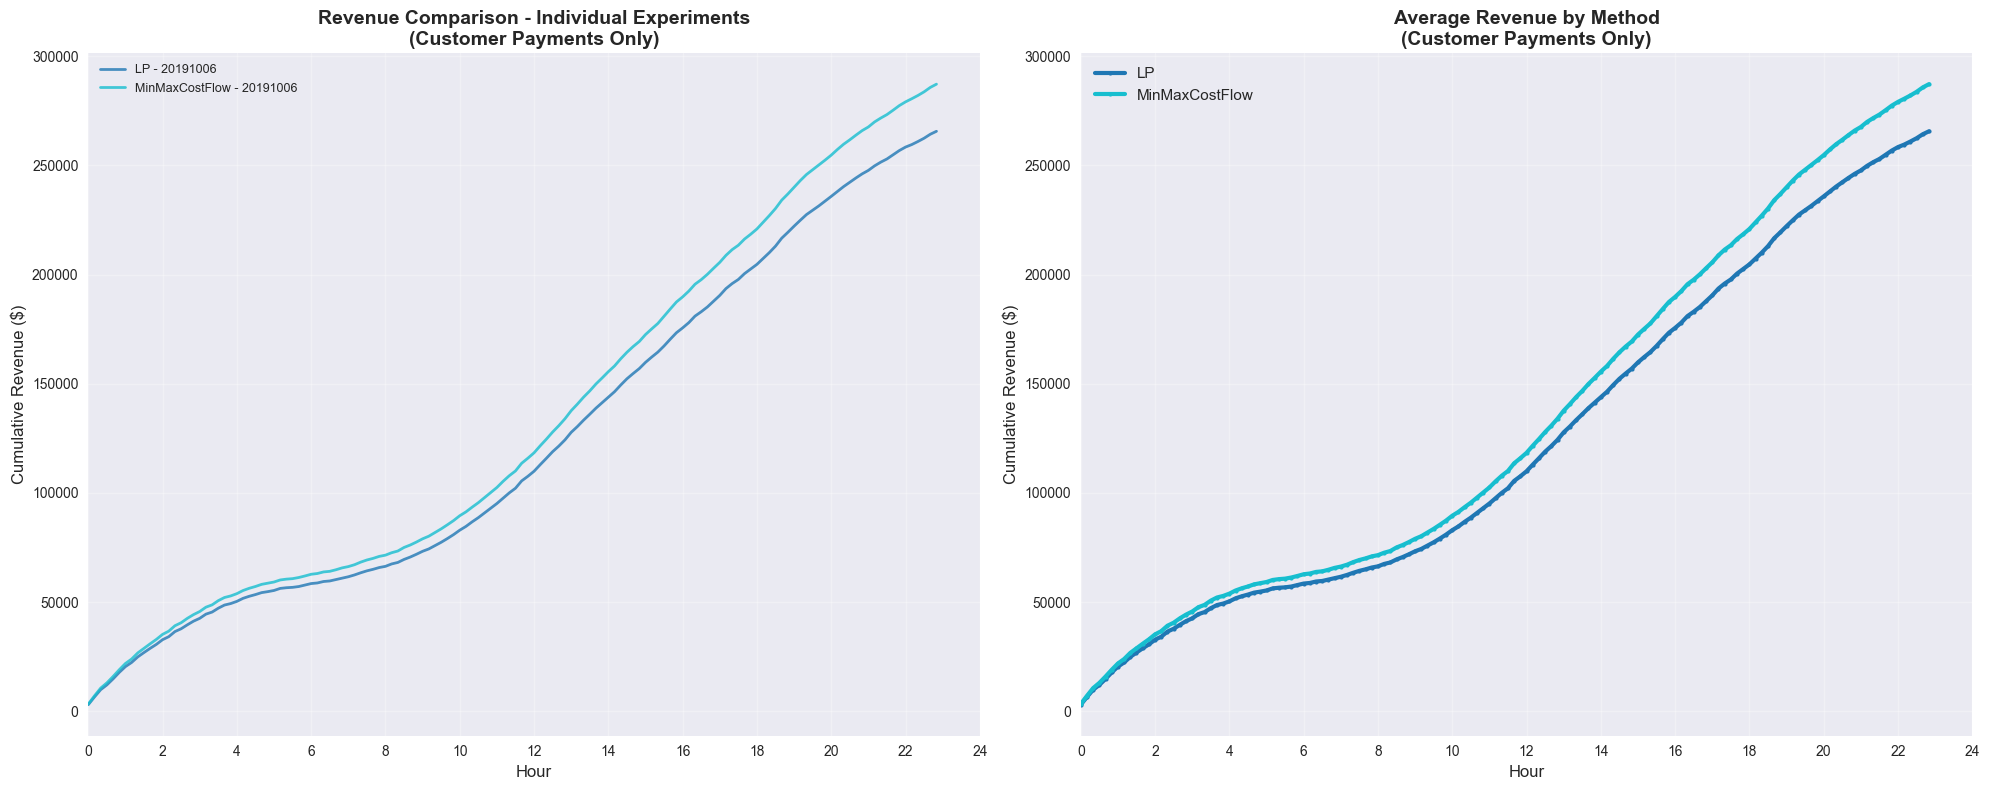


📊 2. Total Value Comparison (System Perspective - NEW!)
💾 Saved: total_value_comparison.png


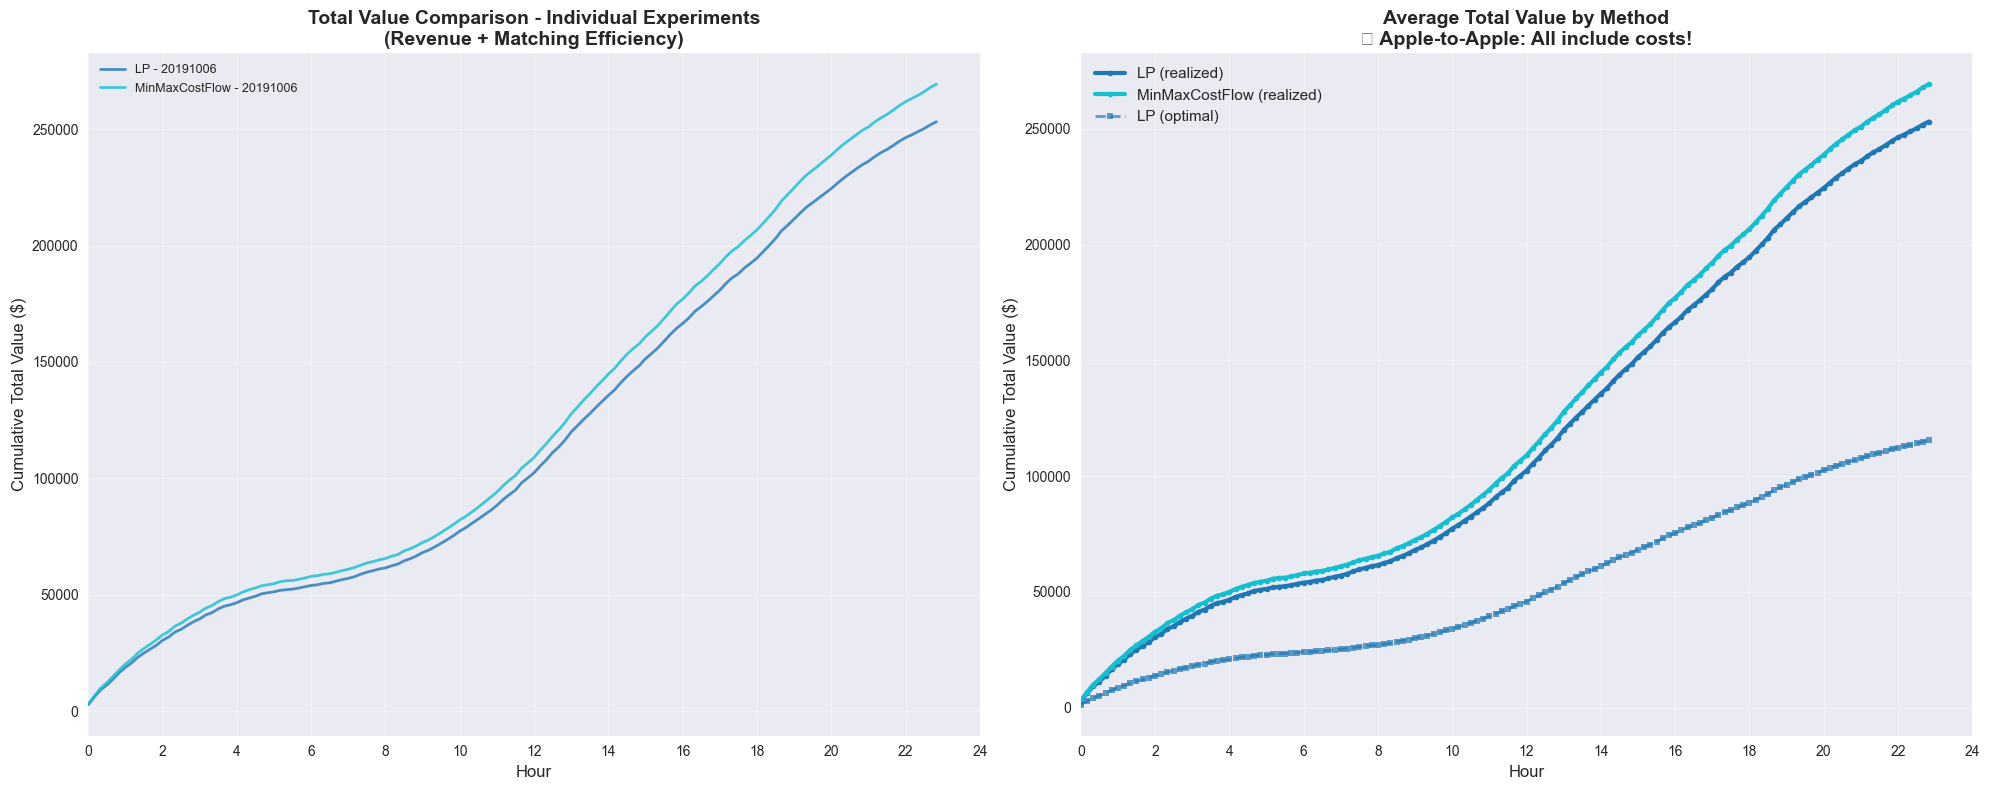


🎉 ANALYSIS COMPLETE!

✅ Generated plots:
  📊 revenue_comparison.png - Customer revenue (what they pay)
  📊 total_value_comparison.png - System value (revenue + costs)

💡 KEY INSIGHTS:
  • Revenue comparison shows which method makes more money from customers
  • Total value shows which method is more efficient overall
  • LP optimal line shows theoretical best (now apple-to-apple!)


In [18]:
# RUN COMPLETE ANALYSIS

print("🚀 Loading experiments from S3...\n")
experiments_data = load_multiple_experiments_s3(EXPERIMENT_IDS)

if not experiments_data:
    print("❌ No data loaded!")
else:
    print(f"\n✅ Loaded {len(experiments_data)} experiments")
    
    # Check data format
    first_df = list(experiments_data.values())[0]
    format_info = check_data_format(first_df)
    
    print("\n" + "="*80)
    print("📊 DATA FORMAT DETECTION")
    print("="*80)
    print(f"  Format: {format_info['format']}")
    print(f"  Has 'total_value' field: {format_info['has_total_value']}")
    print(f"  Has 'edge_weight' field: {format_info['has_edge_weight']}")
    print(f"  Can do total value analysis: {format_info['can_do_total_value_analysis']}")
    
    if format_info['format'] == 'OLD':
        print("\n  ℹ️  This is OLD data (only revenue comparison available)")
        print("     Run new experiments to get 'total_value' for apple-to-apple comparison.")
        print("     See APPLE_TO_APPLE_COMPARISON.md for details.")
    else:
        print("\n  ✅ This is NEW data (both revenue and total value analysis available!)")
    
    # Summary table
    print("\n" + "="*80)
    print("📋 EXPERIMENT SUMMARY")
    print("="*80)
    
    summary = []
    for exp_id, df in experiments_data.items():
        for method in df['method'].unique():
            data = df[df['method'] == method]
            summary_row = {
                'Date': exp_id.split('_')[0],
                'Method': method,
                'Requests': len(data),
                'Revenue': f"${data['profit'].sum():.2f}",
                'Avg_Price': f"${data['price'].mean():.2f}",
                'Accept_Rate': f"{data['sampled_decision'].mean():.3f}",
                'Match_Rate': f"{data['was_matched'].mean():.3f}"
            }
            # Add total_value if available
            if 'total_value' in data.columns:
                summary_row['Total_Value'] = f"${data['total_value'].sum():.2f}"
            summary.append(summary_row)
    
    print(pd.DataFrame(summary).to_string(index=False))
    
    # Generate plots
    print("\n" + "="*80)
    print("🎨 GENERATING PLOTS")
    print("="*80)
    
    print("\n📊 1. Revenue Comparison (Customer Perspective)")
    plot_revenue_comparison(experiments_data)
    
    if format_info['can_do_total_value_analysis']:
        print("\n📊 2. Total Value Comparison (System Perspective - NEW!)")
        plot_total_value_comparison(experiments_data)
    else:
        print("\n⚠️  2. Total Value Comparison - SKIPPED (old data format)")
        print("   Run new experiments to get this analysis.")
    
    print("\n" + "="*80)
    print("🎉 ANALYSIS COMPLETE!")
    print("="*80)
    
    if format_info['format'] == 'NEW':
        print("\n✅ Generated plots:")
        print("  📊 revenue_comparison.png - Customer revenue (what they pay)")
        print("  📊 total_value_comparison.png - System value (revenue + costs)")
        print("\n💡 KEY INSIGHTS:")
        print("  • Revenue comparison shows which method makes more money from customers")
        print("  • Total value shows which method is more efficient overall")
        print("  • LP optimal line shows theoretical best (now apple-to-apple!)")
    else:
        print("\n✅ Generated plots:")
        print("  📊 revenue_comparison.png - Customer revenue")
        print("\n📝 To get total value analysis:")
        print("  1. Run: ./run.sh (will use updated code automatically)")
        print("  2. New data will have 'total_value' field")
        print("  3. Re-run this notebook for apple-to-apple comparison!")